## import packages

In [1]:
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
import lightgbm as lgb
from catboost import Pool, CatBoostRegressor

pd.set_option('display.max_columns', None)

In [2]:
def retype_columns(df):
    """
    cat_features must be integer or string, real number values and NaN values should be converted to string.
    """
    def float_to_categorical(df, col):
        df[col] = df[col] - df[col].min()
        df.loc[df[col].isnull(), col] = -1 # if null set to -1
        df[col] = df[col].astype('int').astype('category')
    
    list_float2categorical = ['cooling_id', 'architecture_style_id', 'framing_id',
                     'heating_id', 'county_id', 'construction_id', 'fips', 'landuse_type_id',
                     'county_landuse_code_id', 'zoning_description_id']
    
    for col in  df.columns:
        if col in list_float2categorical:
            float_to_categorical(df, col)
        elif df[col].dtype.name == 'float64':
            df[col] = df[col].astype(np.float32)

## data loading

In [3]:
dir_temp = '/glade/scratch/wmingch/ML_project/Zillow_prize/temp_data/'
train_combined = pd.read_hdf(dir_temp + 'train_combined.h5', 'train_combined')

In [4]:
retype_columns(train_combined)

In [5]:
train_combined.head()

,parcelid,logerror,cooling_id,architecture_style_id,basement_sqft,bathroom_cnt,bedroom_cnt,framing_id,quality_id,deck_id,floor1_sqft,finished_area_sqft_calc,perimeter_area,floor1_sqft_unk,base_total_area,fips,fireplace_cnt,bathroom_full_cnt,garage_cnt,garage_sqft,spa_flag,heating_id,latitude,longitude,lot_sqft,pool_cnt,pool_total_size,pool_unk_1,pool_unk_2,pool_unk_3,landuse_type_id,census_1,city_id,county_id,neighborhood_id,region_zip,room_cnt,story_id,bathroom_small_cnt,construction_id,unit_cnt,patio_sqft,storage_sqft,year_built,story_cnt,fireplace_flag,tax_structure,tax_parcel,tax_year,tax_land,tax_property,tax_overdue_flag,tax_overdue_year,census_2,county_landuse_code_id,zoning_description_id,avg_garage_size,property_tax_per_sqft,location_1,location_2,location_3,location_4,missing_finished_area,missing_total_area,missing_bathroom_cnt_calc,derived_room_cnt,avg_area_per_room,derived_avg_area_per_room,year,month,quarter
0,11016594,0.0276,0,-1,NaN,2.0,3.0,-1,4.0,NaN,NaN,1684.0,NaN,NaN,NaN,0,NaN,2.0,NaN,NaN,NaN,1,34280992.0,-118488536.0,7528.0,NaN,NaN,NaN,NaN,NaN,230,60371068.0,12447.0,0,31817.0,96370.0,0.0,NaN,NaN,-1,1.0,NaN,NaN,1959.0,NaN,NaN,122754.0,360170.0,2015.0,237416.0,6735.879883,NaN,NaN,6.037107e+13,3,79,NaN,3.999929,-84207544.0,152769520.0,-24963278.0,93525256.0,0.0,1.0,0.0,5.0,NaN,336.799988,0,1,1
1,14366692,-0.1684,-1,-1,NaN,3.5,4.0,-1,NaN,NaN,NaN,2263.0,NaN,NaN,NaN,22,NaN,3.0,2.0,468.0,NaN,-1,33668120.0,-117677552.0,3643.0,NaN,NaN,NaN,NaN,NaN,230,60590524.0,32380.0,1,NaN,96962.0,0.0,NaN,1.0,-1,NaN,NaN,NaN,2014.0,NaN,NaN,346458.0,585529.0,2015.0,239071.0,10153.019531,NaN,NaN,NaN,36,-1,234.0,4.486531,-84009440.0,151345680.0,-25170658.0,92506896.0,0.0,1.0,0.0,7.5,NaN,301.733337,0,1,1
2,12098116,-0.0040,0,-1,NaN,3.0,2.0,-1,4.0,NaN,NaN,2217.0,NaN,NaN,NaN,0,NaN,3.0,NaN,NaN,NaN,1,34136312.0,-118175032.0,11423.0,NaN,NaN,NaN,NaN,NaN,230,60374640.0,47019.0,0,275411.0,96293.0,0.0,NaN,NaN,-1,1.0,NaN,NaN,1940.0,NaN,NaN,61994.0,119906.0,2015.0,57912.0,11484.480469,NaN,NaN,6.037464e+13,3,604,NaN,5.180190,-84038720.0,152311344.0,-24951204.0,93223824.0,0.0,1.0,0.0,5.0,NaN,443.399994,0,1,1
3,12643413,0.0218,0,-1,NaN,2.0,2.0,-1,4.0,NaN,NaN,839.0,NaN,NaN,NaN,0,NaN,2.0,NaN,NaN,NaN,1,33755800.0,-118309000.0,70859.0,NaN,NaN,NaN,NaN,NaN,235,60372964.0,12447.0,0,54300.0,96222.0,0.0,NaN,NaN,-1,1.0,NaN,NaN,1987.0,NaN,NaN,171518.0,244880.0,2015.0,73362.0,3048.739990,NaN,NaN,6.037296e+13,13,626,NaN,3.633778,-84553200.0,152064800.0,-25398700.0,92910304.0,0.0,1.0,0.0,4.0,NaN,209.750000,0,1,1
4,14432541,-0.0050,-1,-1,NaN,2.5,4.0,-1,NaN,NaN,NaN,2283.0,NaN,NaN,NaN,22,NaN,2.0,2.0,598.0,NaN,-1,33485644.0,-117700232.0,6000.0,1.0,NaN,NaN,NaN,1.0,230,60590424.0,17686.0,1,NaN,96961.0,8.0,NaN,1.0,-1,NaN,NaN,NaN,1981.0,2.0,NaN,169574.0,434551.0,2015.0,264977.0,5488.959961,NaN,NaN,6.059042e+13,16,-1,299.0,2.404275,-84214592.0,151185872.0,-25364474.0,92335760.0,0.0,1.0,0.0,6.5,285.375,351.230774,0,1,1


In [6]:
properties_2016_df = pd.read_hdf(dir_temp + 'properties_2016.h5', 'properties_2016_df')
properties_2017_df = pd.read_hdf(dir_temp + 'properties_2017.h5', 'properties_2017_df')

In [7]:
retype_columns(properties_2016_df)
retype_columns(properties_2017_df)

In [8]:
properties_2016_df.head()

,parcelid,cooling_id,architecture_style_id,basement_sqft,bathroom_cnt,bedroom_cnt,framing_id,quality_id,deck_id,floor1_sqft,finished_area_sqft_calc,perimeter_area,floor1_sqft_unk,base_total_area,fips,fireplace_cnt,bathroom_full_cnt,garage_cnt,garage_sqft,spa_flag,heating_id,latitude,longitude,lot_sqft,pool_cnt,pool_total_size,pool_unk_1,pool_unk_2,pool_unk_3,landuse_type_id,census_1,city_id,county_id,neighborhood_id,region_zip,room_cnt,story_id,bathroom_small_cnt,construction_id,unit_cnt,patio_sqft,storage_sqft,year_built,story_cnt,fireplace_flag,tax_structure,tax_parcel,tax_year,tax_land,tax_property,tax_overdue_flag,tax_overdue_year,census_2,county_landuse_code_id,zoning_description_id,avg_garage_size,property_tax_per_sqft,location_1,location_2,location_3,location_4,missing_finished_area,missing_total_area,missing_bathroom_cnt_calc,derived_room_cnt,avg_area_per_room,derived_avg_area_per_room
0,10754147,-1,-1,NaN,0.0,0.0,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,-1,34144440.0,-118654080.0,85768.0,NaN,NaN,NaN,NaN,NaN,238,60378004.0,37688.0,0,NaN,96337.0,0.0,NaN,NaN,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.0,2015.0,9.0,NaN,NaN,NaN,NaN,43,-1,NaN,NaN,-84509640.0,152798528.0,-25182600.0,93471488.0,1.0,1.0,1.0,0.0,NaN,NaN
1,10759547,-1,-1,NaN,0.0,0.0,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,-1,34140432.0,-118625360.0,4083.0,NaN,NaN,NaN,NaN,NaN,230,60378000.0,37688.0,0,NaN,96337.0,0.0,NaN,NaN,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27516.0,2015.0,27516.0,NaN,NaN,NaN,NaN,28,279,NaN,NaN,-84484936.0,152765792.0,-25172252.0,93453112.0,1.0,1.0,1.0,0.0,NaN,NaN
2,10843547,-1,-1,NaN,0.0,0.0,-1,NaN,NaN,NaN,73026.0,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,-1,33989360.0,-118394632.0,63085.0,NaN,NaN,NaN,NaN,NaN,16,60377032.0,51617.0,0,NaN,96095.0,0.0,NaN,NaN,-1,2.0,NaN,NaN,NaN,NaN,NaN,650756.0,1413387.0,2015.0,762631.0,20800.369141,NaN,NaN,NaN,25,411,NaN,0.284835,-84405272.0,152384000.0,-25207958.0,93186672.0,1.0,0.0,1.0,0.0,NaN,NaN
3,10859147,-1,-1,NaN,0.0,0.0,2,7.0,NaN,NaN,5068.0,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,-1,34148864.0,-118437208.0,7521.0,NaN,NaN,NaN,NaN,NaN,16,60371412.0,12447.0,0,27080.0,96424.0,0.0,NaN,NaN,-1,NaN,NaN,NaN,1948.0,1.0,NaN,571346.0,1156834.0,2015.0,585488.0,14557.570312,NaN,NaN,NaN,25,411,NaN,2.872449,-84288344.0,152586064.0,-25069740.0,93367464.0,1.0,0.0,1.0,0.0,NaN,NaN
4,10879947,-1,-1,NaN,0.0,0.0,3,NaN,NaN,NaN,1776.0,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,-1,34194168.0,-118385816.0,8512.0,NaN,NaN,NaN,NaN,NaN,0,60371232.0,12447.0,0,46795.0,96450.0,0.0,NaN,NaN,-1,1.0,NaN,NaN,1947.0,NaN,NaN,193796.0,433491.0,2015.0,239695.0,5725.169922,NaN,NaN,NaN,48,194,NaN,3.223632,-84191648.0,152579984.0,-24998740.0,93387072.0,1.0,0.0,1.0,0.0,NaN,NaN


## training preparation 

In [9]:
def drop_features(train):
    # parcelid and label (not features)
    unused_feature_list = ['parcelid', 'logerror']
    
    # too many missing (LightGBM is robust against bad/unrelated features, so this step might not be needed)
    missing_list = ['framing_id', 'architecture_style_id', 'story_id', 'perimeter_area', 'basement_sqft', 'storage_sqft']
    unused_feature_list += missing_list
    
    # not useful
    bad_feature_list = ['fireplace_flag', 'deck_id', 'pool_unk_1', 'construction_id', 'county_id', 'fips']
    unused_feature_list += bad_feature_list
    
    # really hurts performance
    unused_feature_list += ['county_landuse_code_id', 'zoning_description_id']
    
    return train.drop(unused_feature_list, axis=1, errors='ignore')

In [10]:
catboost_features = drop_features(train_combined)
print('Number of features for LightGBM: {}'.format(len(catboost_features.columns)))
catboost_features.head()

Number of features for LightGBM: 55


,cooling_id,bathroom_cnt,bedroom_cnt,quality_id,floor1_sqft,finished_area_sqft_calc,floor1_sqft_unk,base_total_area,fireplace_cnt,bathroom_full_cnt,garage_cnt,garage_sqft,spa_flag,heating_id,latitude,longitude,lot_sqft,pool_cnt,pool_total_size,pool_unk_2,pool_unk_3,landuse_type_id,census_1,city_id,neighborhood_id,region_zip,room_cnt,bathroom_small_cnt,unit_cnt,patio_sqft,year_built,story_cnt,tax_structure,tax_parcel,tax_year,tax_land,tax_property,tax_overdue_flag,tax_overdue_year,census_2,avg_garage_size,property_tax_per_sqft,location_1,location_2,location_3,location_4,missing_finished_area,missing_total_area,missing_bathroom_cnt_calc,derived_room_cnt,avg_area_per_room,derived_avg_area_per_room,year,month,quarter
0,0,2.0,3.0,4.0,NaN,1684.0,NaN,NaN,NaN,2.0,NaN,NaN,NaN,1,34280992.0,-118488536.0,7528.0,NaN,NaN,NaN,NaN,230,60371068.0,12447.0,31817.0,96370.0,0.0,NaN,1.0,NaN,1959.0,NaN,122754.0,360170.0,2015.0,237416.0,6735.879883,NaN,NaN,6.037107e+13,NaN,3.999929,-84207544.0,152769520.0,-24963278.0,93525256.0,0.0,1.0,0.0,5.0,NaN,336.799988,0,1,1
1,-1,3.5,4.0,NaN,NaN,2263.0,NaN,NaN,NaN,3.0,2.0,468.0,NaN,-1,33668120.0,-117677552.0,3643.0,NaN,NaN,NaN,NaN,230,60590524.0,32380.0,NaN,96962.0,0.0,1.0,NaN,NaN,2014.0,NaN,346458.0,585529.0,2015.0,239071.0,10153.019531,NaN,NaN,NaN,234.0,4.486531,-84009440.0,151345680.0,-25170658.0,92506896.0,0.0,1.0,0.0,7.5,NaN,301.733337,0,1,1
2,0,3.0,2.0,4.0,NaN,2217.0,NaN,NaN,NaN,3.0,NaN,NaN,NaN,1,34136312.0,-118175032.0,11423.0,NaN,NaN,NaN,NaN,230,60374640.0,47019.0,275411.0,96293.0,0.0,NaN,1.0,NaN,1940.0,NaN,61994.0,119906.0,2015.0,57912.0,11484.480469,NaN,NaN,6.037464e+13,NaN,5.180190,-84038720.0,152311344.0,-24951204.0,93223824.0,0.0,1.0,0.0,5.0,NaN,443.399994,0,1,1
3,0,2.0,2.0,4.0,NaN,839.0,NaN,NaN,NaN,2.0,NaN,NaN,NaN,1,33755800.0,-118309000.0,70859.0,NaN,NaN,NaN,NaN,235,60372964.0,12447.0,54300.0,96222.0,0.0,NaN,1.0,NaN,1987.0,NaN,171518.0,244880.0,2015.0,73362.0,3048.739990,NaN,NaN,6.037296e+13,NaN,3.633778,-84553200.0,152064800.0,-25398700.0,92910304.0,0.0,1.0,0.0,4.0,NaN,209.750000,0,1,1
4,-1,2.5,4.0,NaN,NaN,2283.0,NaN,NaN,NaN,2.0,2.0,598.0,NaN,-1,33485644.0,-117700232.0,6000.0,1.0,NaN,NaN,1.0,230,60590424.0,17686.0,NaN,96961.0,8.0,1.0,NaN,NaN,1981.0,2.0,169574.0,434551.0,2015.0,264977.0,5488.959961,NaN,NaN,6.059042e+13,299.0,2.404275,-84214592.0,151185872.0,-25364474.0,92335760.0,0.0,1.0,0.0,6.5,285.375,351.230774,0,1,1


In [11]:
# target 
catboost_label = train_combined.logerror.astype(np.float32)

# transform to Numpy matrices
catboost_X = catboost_features.values
catboost_y = catboost_label.values

# train and test split 
X_train, X_val, y_train, y_val = train_test_split(catboost_X, catboost_y, test_size=0.2,  random_state=26)
print("X_train shape: {}".format(X_train.shape))
print("y_train shape: {}".format(y_train.shape))
print("X_val shape: {}".format(X_val.shape))
print("y_val shape: {}".format(y_val.shape))

#remove outlier from X_train and y_train
outlier_threshold = 0.4
mask = (abs(y_train) <= outlier_threshold)
# X_train = X_train.loc[abs(y_train) <= outlier_threshold]
# y_train = y_train.loc[abs(y_train) <= outlier_threshold]
X_train = X_train[mask,:]
y_train = y_train[mask]

print("...... After remove outlier abs(logerror) > 0.4 ......")
print("X_train shape: {}".format(X_train.shape))
print("y_train shape: {}".format(y_train.shape))
print("X_val shape: {}".format(X_val.shape))
print("y_val shape: {}".format(y_val.shape))

X_train shape: (134310, 55)
y_train shape: (134310,)
X_val shape: (33578, 55)
y_val shape: (33578,)
...... After remove outlier abs(logerror) > 0.4 ......
X_train shape: (131445, 55)
y_train shape: (131445,)
X_val shape: (33578, 55)
y_val shape: (33578,)


In [12]:
# Specify feature names and categorical features for LightGBM
feature_names = [s for s in catboost_features.columns]
categorical_features = ['cooling_id', 'heating_id', 'landuse_type_id', 'year', 'month', 'quarter']

categorical_indices = []
for idx, val in enumerate(catboost_features.columns):
    if val in categorical_features:
        print(val)
        categorical_indices.append(idx)
print(categorical_indices)

cooling_id
heating_id
landuse_type_id
year
month
quarter
[0, 13, 21, 52, 53, 54]


## CatBoost 

In [13]:
# parameters 
# reference: https://catboost.ai/en/docs/references/training-parameters/

params = {}

params['loss_function'] = 'MAE'
params['eval_metric'] = 'MAE'
params['nan_mode'] = 'Min'  # Method to handle NaN (set NaN to either Min or Max)
params['random_seed'] = 0

params['iterations'] = 1000  # default 1000, use early stopping during training
params['learning_rate'] = 0.015  # default 0.03

params['border_count'] = 254  # default 254 (alias max_bin, suggested to keep at default for best quality)

params['max_depth'] = 6  # default 6 (must be <= 16, 6 to 10 is recommended)
params['random_strength'] = 1  # default 1 (used during splitting to deal with overfitting, try different values)
params['l2_leaf_reg'] = 5  # default 3 (Coefficient at the L2 regularization term of the cost function, try different values)
params['bagging_temperature'] = 1  # default 1 (higher value -> more aggressive bagging, try different values)

In [14]:
val_pool  = Pool(X_val, y_val, cat_features=categorical_indices)
model = CatBoostRegressor(**params)
model.fit(X_train, y_train, cat_features=categorical_indices, 
         use_best_model=True, eval_set=val_pool, early_stopping_rounds=50, verbose=False)

In [15]:
print('Train score: {}'.format(abs(model.predict(X_train)-y_train).mean()))
print('Valid score: {}'.format(abs(model.predict(X_val)-y_val).mean()))

Train score: 0.0513448137643249
Valid score: 0.06834130660311524


In [16]:
# get feature importance

def plot_feature_importance(importance,names):
    
    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    
    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    
    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    
    #Define size of bar plot
    plt.figure(figsize=(12,12))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.xlabel('Feature Importances')
    plt.ylabel('Feature Names')

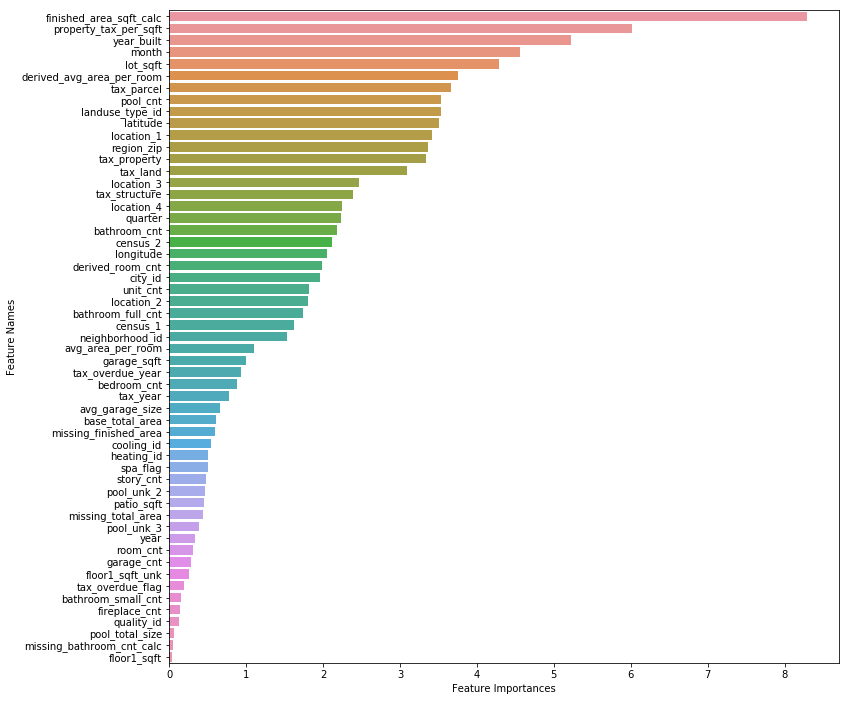

In [17]:
plot_feature_importance(model.get_feature_importance(), feature_names)

## train on all data 

In [18]:
#remove outlier from X_train and y_train
outlier_threshold = 0.4
mask = (abs(catboost_y) <= outlier_threshold)
catboost_whole_X = catboost_X[mask, :]
catboost_whole_y = catboost_y[mask]
print("Whole train_X: {}".format(catboost_whole_X.shape))
print("Whole train_y: {}".format(catboost_whole_y.shape))

Whole train_X: (164299, 55)
Whole train_y: (164299,)


In [19]:
model = CatBoostRegressor(**params)
model.fit(catboost_whole_X, catboost_whole_y, cat_features=categorical_indices, verbose=False)

In [20]:
print('Whole Train score: {}'.format(abs(model.predict(catboost_whole_X) - catboost_whole_y).mean()))

Whole Train score: 0.05146905300736526


## make predictions 

In [21]:
submission_sample = pd.read_csv('/glade/scratch/wmingch/ML_project/Zillow_prize/sample_submission.csv')

In [22]:
submission_sample.head()

,ParcelId,201610,201611,201612,201710,201711,201712
0,10754147,0,0,0,0,0,0
1,10759547,0,0,0,0,0,0
2,10843547,0,0,0,0,0,0
3,10859147,0,0,0,0,0,0
4,10879947,0,0,0,0,0,0


In [23]:
def transform_test_features(properties_2016_df, properties_2017_df):
    properties_2016_df_transform = drop_features(properties_2016_df)
    properties_2017_df_transform = drop_features(properties_2017_df)
    
    properties_2016_df_transform['year'] = 0
    properties_2016_df_transform['month'] = 10
    properties_2016_df_transform['quarter'] = 4
    
    properties_2017_df_transform['year'] = 1
    properties_2017_df_transform['month'] = 10
    properties_2017_df_transform['quarter'] = 4
    
    return properties_2016_df_transform, properties_2017_df_transform

In [24]:
def predict_and_output(models, properties_2016_df, properties_2017_df, file_name):
    submission_2016 = pd.DataFrame()
    submission_2017 = pd.DataFrame()
    submission_2016['ParcelId'] = properties_2016_df['parcelid']
    submission_2017['ParcelId'] = properties_2017_df['parcelid']
    
    properties_2016_df_transform, properties_2017_df_transform = transform_test_features(properties_2016_df, properties_2017_df)
    pred_2016, pred_2017 = [], []
    for i, model in enumerate(models):
        print('Start model {} (2016)'.format(i))
        pred_2016.append(model.predict(properties_2016_df_transform))
        print('Start model {} (2017)'.format(i))
        pred_2017.append(model.predict(properties_2017_df_transform))
    
    # take ensemble mean 
    mean_pred_2016 = np.mean(pred_2016, axis=0)
    mean_pred_2017 = np.mean(pred_2017, axis=0)
    
    submission_2016['201610'] = [float(format(x, '.4f')) for x in mean_pred_2016]
    submission_2016['201611'] = submission_2016['201610']
    submission_2016['201612'] = submission_2016['201610']

    submission_2017['201710'] = [float(format(x, '.4f')) for x in mean_pred_2017]
    submission_2017['201711'] = submission_2017['201710']
    submission_2017['201712'] = submission_2017['201710']
    
    submission = submission_2016.merge(how='inner', right=submission_2017, on='ParcelId')
    print(submission.head())
    submission.to_csv(file_name, index=False)
    
    return submission, submission_2016, submission_2017

In [25]:
%%time
file_name = dir_temp + 'CatBoost/CatBoost_single.csv'
predict_and_output([model], properties_2016_df, properties_2017_df, file_name)

Start model 0 (2016)
Start model 0 (2017)
   ParcelId  201610  201611  201612  201710  201711  201712
0  10754147  0.0041  0.0041  0.0041  0.0066  0.0066  0.0066
1  10759547  0.0051  0.0051  0.0051  0.0056  0.0056  0.0056
2  10843547  0.0195  0.0195  0.0195  0.0204  0.0204  0.0204
3  10859147  0.0149  0.0149  0.0149  0.0158  0.0158  0.0158
4  10879947  0.0070  0.0070  0.0070  0.0066  0.0066  0.0066
CPU times: user 34.6 s, sys: 1.45 s, total: 36.1 s
Wall time: 28.9 s


(          ParcelId  201610  201611  201612  201710  201711  201712
 0         10754147  0.0041  0.0041  0.0041  0.0066  0.0066  0.0066
 1         10759547  0.0051  0.0051  0.0051  0.0056  0.0056  0.0056
 2         10843547  0.0195  0.0195  0.0195  0.0204  0.0204  0.0204
 3         10859147  0.0149  0.0149  0.0149  0.0158  0.0158  0.0158
 4         10879947  0.0070  0.0070  0.0070  0.0066  0.0066  0.0066
 ...            ...     ...     ...     ...     ...     ...     ...
 2985212  168176230  0.0035  0.0035  0.0035  0.0074  0.0074  0.0074
 2985213   14273630  0.0035  0.0035  0.0035  0.0129  0.0129  0.0129
 2985214  168040630  0.0035  0.0035  0.0035  0.0031  0.0031  0.0031
 2985215  168040830  0.0035  0.0035  0.0035  0.0139  0.0139  0.0139
 2985216  168040430  0.0035  0.0035  0.0035  0.0051  0.0051  0.0051
 
 [2985217 rows x 7 columns],           ParcelId  201610  201611  201612
 0         10754147  0.0041  0.0041  0.0041
 1         10759547  0.0051  0.0051  0.0051
 2         10843547  0

## Ensemble Training 

In [26]:
params

{'loss_function': 'MAE',
 'eval_metric': 'MAE',
 'nan_mode': 'Min',
 'random_seed': 0,
 'iterations': 1000,
 'learning_rate': 0.015,
 'border_count': 254,
 'max_depth': 6,
 'random_strength': 1,
 'l2_leaf_reg': 5,
 'bagging_temperature': 1}

In [27]:
# multiple models with different random_seed
num_models = 8
models = []
for i in range(num_models):
    print('Training model {}'.format(i))
    params['random_seed'] = i
    model = CatBoostRegressor(**params)
    model.fit(catboost_whole_X, catboost_whole_y, cat_features=categorical_indices, verbose=False)
    models.append(model)
    model = None

Training model 0
Training model 1
Training model 2
Training model 3
Training model 4
Training model 5
Training model 6
Training model 7


In [29]:
%%time
# print training score for each model 
for idx, model in enumerate(models):
    print('model {}, train score: {}'.format(idx, abs(model.predict(catboost_whole_X)-catboost_whole_y).mean()))

model 0, train score: 0.05146905300736526
model 1, train score: 0.05146627178750766
model 2, train score: 0.0514510861949116
model 3, train score: 0.0514594159696789
model 4, train score: 0.051453747747308945
model 5, train score: 0.05146906207769754
model 6, train score: 0.05145518256397149
model 7, train score: 0.051468915297254746
CPU times: user 8.43 s, sys: 89.4 ms, total: 8.52 s
Wall time: 6.88 s


In [30]:
def save_models(models):
    for i, model in enumerate(models):
        print('save catboost model {}'.format(i))
        model.save_model(dir_temp + 'CatBoost/catboost_model_' + str(i))

In [31]:
save_models(models)

save catboost model 0
save catboost model 1
save catboost model 2
save catboost model 3
save catboost model 4
save catboost model 5
save catboost model 6
save catboost model 7


In [32]:
%%time

# make predictions based on ensemble
file_name = dir_temp + 'CatBoost/CatBoost_X8.csv'
predict_and_output(models, properties_2016_df, properties_2017_df, file_name)

Start model 0 (2016)
Start model 0 (2017)
Start model 1 (2016)
Start model 1 (2017)
Start model 2 (2016)
Start model 2 (2017)
Start model 3 (2016)
Start model 3 (2017)
Start model 4 (2016)
Start model 4 (2017)
Start model 5 (2016)
Start model 5 (2017)
Start model 6 (2016)
Start model 6 (2017)
Start model 7 (2016)
Start model 7 (2017)
   ParcelId  201610  201611  201612  201710  201711  201712
0  10754147  0.0032  0.0032  0.0032  0.0034  0.0034  0.0034
1  10759547  0.0036  0.0036  0.0036  0.0040  0.0040  0.0040
2  10843547  0.0084  0.0084  0.0084  0.0105  0.0105  0.0105
3  10859147  0.0185  0.0185  0.0185  0.0204  0.0204  0.0204
4  10879947  0.0091  0.0091  0.0091  0.0100  0.0100  0.0100
CPU times: user 2min 10s, sys: 1.9 s, total: 2min 12s
Wall time: 1min 15s


(          ParcelId  201610  201611  201612  201710  201711  201712
 0         10754147  0.0032  0.0032  0.0032  0.0034  0.0034  0.0034
 1         10759547  0.0036  0.0036  0.0036  0.0040  0.0040  0.0040
 2         10843547  0.0084  0.0084  0.0084  0.0105  0.0105  0.0105
 3         10859147  0.0185  0.0185  0.0185  0.0204  0.0204  0.0204
 4         10879947  0.0091  0.0091  0.0091  0.0100  0.0100  0.0100
 ...            ...     ...     ...     ...     ...     ...     ...
 2985212  168176230  0.0051  0.0051  0.0051  0.0077  0.0077  0.0077
 2985213   14273630  0.0051  0.0051  0.0051  0.0097  0.0097  0.0097
 2985214  168040630  0.0051  0.0051  0.0051  0.0035  0.0035  0.0035
 2985215  168040830  0.0051  0.0051  0.0051  0.0120  0.0120  0.0120
 2985216  168040430  0.0051  0.0051  0.0051  0.0050  0.0050  0.0050
 
 [2985217 rows x 7 columns],           ParcelId  201610  201611  201612
 0         10754147  0.0032  0.0032  0.0032
 1         10759547  0.0036  0.0036  0.0036
 2         10843547  0

## stack the predictions of lightGBM and CatBoost

In [33]:
lgb_single = pd.read_csv(dir_temp + 'LightGBM/LightGBM_single.csv')
catboost_x8 = pd.read_csv(dir_temp + 'CatBoost/CatBoost_X8.csv')

In [34]:
lgb_single.columns

Index(['ParcelId', '201610', '201611', '201612', '201710', '201711', '201712'], dtype='object')

In [36]:
weight = 0.5
stack = pd.DataFrame()
stack['ParcelId'] = lgb_single.ParcelId
for col in lgb_single.columns[1:]:
    stack[col] = weight * lgb_single[col] + (1-weight) * catboost_x8[col]

In [37]:
stack.head()

,ParcelId,201610,201611,201612,201710,201711,201712
0,10754147,-0.01025,-0.01025,-0.01025,-0.00820,-0.00820,-0.00820
1,10759547,-0.00715,-0.00715,-0.00715,-0.00625,-0.00625,-0.00625
2,10843547,0.00895,0.00895,0.00895,0.01610,0.01610,0.01610
3,10859147,0.02305,0.02305,0.02305,0.02400,0.02400,0.02400
4,10879947,0.00355,0.00355,0.00355,0.00425,0.00425,0.00425


In [38]:
file_name = dir_temp + 'CatBoost/Stack_CatBoost_X8_with_lgb.csv'
stack.to_csv(file_name, index=False)